# Airbnb dataset

Model to predict price from available features

In [1]:
from utilsML import get_indexes_from_list, get_elements_from_list
from utilsML import plot_bars, plot_density, plot_correlation_vs_mi, plot_estimator_feature_contquant, plot_estimator_feature_qualit_bi

import numpy  as np  
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### Load data

In [2]:
# load data
airbnb_data = pd.read_csv("./data/airbnb-listings-extract.csv", delimiter = ';') # load data
print(f'Number of samples: {airbnb_data.shape[0]}\nNumber of features: {airbnb_data.shape[1]}')

Number of samples: 14780
Number of features: 89


In [3]:
dupl = sum(airbnb_data['ID'].duplicated())
print(f'Number of duplicated ID: {dupl}')

Number of duplicated ID: 0


#### Split data train/test

In [4]:
# split train and test
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    airbnb_data, test_size = 0.3, shuffle = True, random_state = 0
)

#### Initial cleaning process

Most accommodations are located in Madrid. Only data from Madrid will be used.

In [5]:
df_train[df_train['Smart Location'].str.contains('Spain', na = False)]['Smart Location'].value_counts().head(5)

Smart Location
Madrid, Spain       9243
Barcelona, Spain     209
马德里, Spain            42
Palma, Spain          37
Alcúdia, Spain        29
Name: count, dtype: int64

In [6]:
df_train_madrid = df_train[df_train['Smart Location'] == 'Madrid, Spain']

Unuseful features are removed

In [7]:
features_to_remove = [
    'ID','Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Space', 'Neighborhood Overview',
    'Summary', 'Description', 'Notes', 'Transit', 'Access', 'Interaction', 'Thumbnail Url',
    'Medium Url', 'Picture Url', 'House Rules', 'XL Picture Url', 'Host ID', 'Host URL',
    'Host Name', 'Host About', 'Host Response Time', 'Host Thumbnail Url', 'Host Picture Url',
    'Host Verifications', 'Neighbourhood', 'Host Neighbourhood', 'Street' ,'Host Location' ,'City',
    'State', 'Market', 'Smart Location', 'Country Code', 'Country', 'Host Acceptance Rate',
    'Host Listings Count', 'Geolocation', 'Calendar last Scraped', 'Calendar Updated',
    'Has Availability', 'Weekly Price', 'Monthly Price', 'First Review', 'Last Review', 'License',
    'Jurisdiction Names', 'Reviews per Month', 'Host Response Rate', 'Zipcode', 'Review Scores Accuracy',
    'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication' , 
    'Review Scores Location', 'Review Scores Value', 'Experiences Offered',
    'Neighbourhood Group Cleansed', 'Neighbourhood Cleansed', 'Extra People', 
    'Minimum Nights', 'Maximum Nights', 'Property Type']
df_train_clean = df_train_madrid.drop(features_to_remove, axis=1)


In [8]:
df_train_clean.shape

(9243, 25)

In [9]:
df_train_clean.dtypes

Host Since                         object
Host Total Listings Count         float64
Latitude                          float64
Longitude                         float64
Room Type                          object
Accommodates                        int64
Bathrooms                         float64
Bedrooms                          float64
Beds                              float64
Bed Type                           object
Amenities                          object
Square Feet                       float64
Price                             float64
Security Deposit                  float64
Cleaning Fee                      float64
Guests Included                     int64
Availability 30                     int64
Availability 60                     int64
Availability 90                     int64
Availability 365                    int64
Number of Reviews                   int64
Review Scores Rating              float64
Cancellation Policy                object
Calculated host listings count    

### Feature Engineering

Several qualitative features are extracted from **Amenities** feature

In [10]:
df_train_clean['Internet'] = df_train_clean['Amenities'].str.contains('Internet', na = False).astype(int)
df_train_clean['AirCond'] = df_train_clean['Amenities'].str.contains('Air conditioning', na = False).astype(int)
df_train_clean['Elevator'] = df_train_clean['Amenities'].str.contains('Elevator in building', na = False).astype(int)
df_train_clean = df_train_clean.drop(['Amenities'], axis = 1)

**SuperHost** qualitative feature is extracted from **Features** feature

In [11]:
df_train_clean['SuperHost'] = df_train_clean['Features'].str.contains('Host Is Superhost', na = False).astype(int)
df_train_clean = df_train_clean.drop(['Features'], axis = 1)

New feature **months_old** from **Host Since**: time in months that the accommodation has been operating

In [12]:
df_train_clean['Host Since'] = pd.to_datetime(df_train_clean['Host Since'])
today = pd.Timestamp.today()
df_train_clean['months_old'] = (
    (today.year - df_train_clean['Host Since'].dt.year) * 12 + 
    (today.month - df_train_clean['Host Since'].dt.month)
)
df_train_clean = df_train_clean.drop(['Host Since'], axis = 1)

Handling missing data

In [13]:
na_counts = df_train_clean.isna().sum()
na_counts[na_counts > 0]

Host Total Listings Count       2
Bathrooms                      35
Bedrooms                       18
Beds                           34
Square Feet                  8887
Price                           8
Security Deposit             5235
Cleaning Fee                 3717
Review Scores Rating         2007
months_old                      2
dtype: int64

In [14]:
# Remove samples without info about Price
df_train_clean = df_train_clean[np.logical_not(df_train_clean['Price'].isna())]
# Remove samples without info about Bathrooms
df_train_clean = df_train_clean[np.logical_not(df_train_clean['Bathrooms'].isna())]
# Remove samples without info about Bedrooms
df_train_clean = df_train_clean[np.logical_not(df_train_clean['Bedrooms'].isna())]
# Remove samples without info about Beds and Bedrooms
df_train_clean = df_train_clean[np.logical_not(df_train_clean['Beds'].isna() & df_train_clean['Bedrooms'].isna())]
# Remove samples without info about months_old
df_train_clean = df_train_clean[np.logical_not(df_train_clean['months_old'].isna())]
# Impute Beds with value from Bedrooms
df_train_clean['Beds'] = df_train_clean['Beds'].fillna(df_train_clean['Bedrooms'])
# Impute sample without info about Cleaning Fee to median
cleaning_fee_median = df_train_clean['Cleaning Fee'].median()
df_train_clean['Cleaning Fee'] = df_train_clean['Cleaning Fee'].fillna(cleaning_fee_median)
# Impute sample without info about Review Scores Rating to median
review_rating_median = df_train_clean['Review Scores Rating'].median()
df_train_clean['Review Scores Rating'] = df_train_clean['Review Scores Rating'].fillna(review_rating_median)
df_train_clean = df_train_clean.drop(['Square Feet', 'Security Deposit'], axis = 1)
na_counts = df_train_clean.isna().sum()
na_counts[na_counts > 0]

Series([], dtype: int64)

In [15]:
df_train_clean.head().T

,4706,6422,4339,1666,4578
Host Total Listings Count,40.0,1.0,3.0,1.0,4.0
Latitude,40.415418,40.411131,40.42805,40.396449,40.413447
Longitude,-3.707123,-3.707258,-3.676042,-3.7141,-3.718438
Room Type,Entire home/apt,Entire home/apt,Private room,Entire home/apt,Entire home/apt
Accommodates,4,4,2,6,3
Bathrooms,1.0,1.0,1.0,1.0,1.0
Bedrooms,1.0,1.0,1.0,3.0,2.0
Beds,2.0,2.0,1.0,4.0,2.0
Bed Type,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed
Price,85.0,49.0,33.0,35.0,54.0


#### Exploratory data analysis

In [16]:
df_train_clean.dtypes

Host Total Listings Count         float64
Latitude                          float64
Longitude                         float64
Room Type                          object
Accommodates                        int64
Bathrooms                         float64
Bedrooms                          float64
Beds                              float64
Bed Type                           object
Price                             float64
Cleaning Fee                      float64
Guests Included                     int64
Availability 30                     int64
Availability 60                     int64
Availability 90                     int64
Availability 365                    int64
Number of Reviews                   int64
Review Scores Rating              float64
Cancellation Policy                object
Calculated host listings count    float64
Internet                            int64
AirCond                             int64
Elevator                            int64
SuperHost                         

Classify features

In [17]:
features = {'qualitative': ['Room Type', 'Bed Type', 'Cancellation Policy', 'Internet',
                           'AirCond', 'Elevator', 'SuperHost'],
            'discreteQuantitative': ['Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 
                                     'Guests Included'],
            'contQuantitative': ['Host Total Listings Count', 'Latitude', 'Longitude', 'Price', 
                                 'Cleaning Fee', 'Availability 30',
                                 'Availability 60', 'Availability 90', 'Availability 365',
                                 'Number of Reviews', 'Review Scores Rating', 
                                 'Calculated host listings count', 'months_old']}

Transform **Bathrooms** feature into an integer using ceiling rounding

In [18]:
df_train_clean['Bathrooms'] = np.ceil(df_train_clean['Bathrooms'])

Plot discrete quantitative

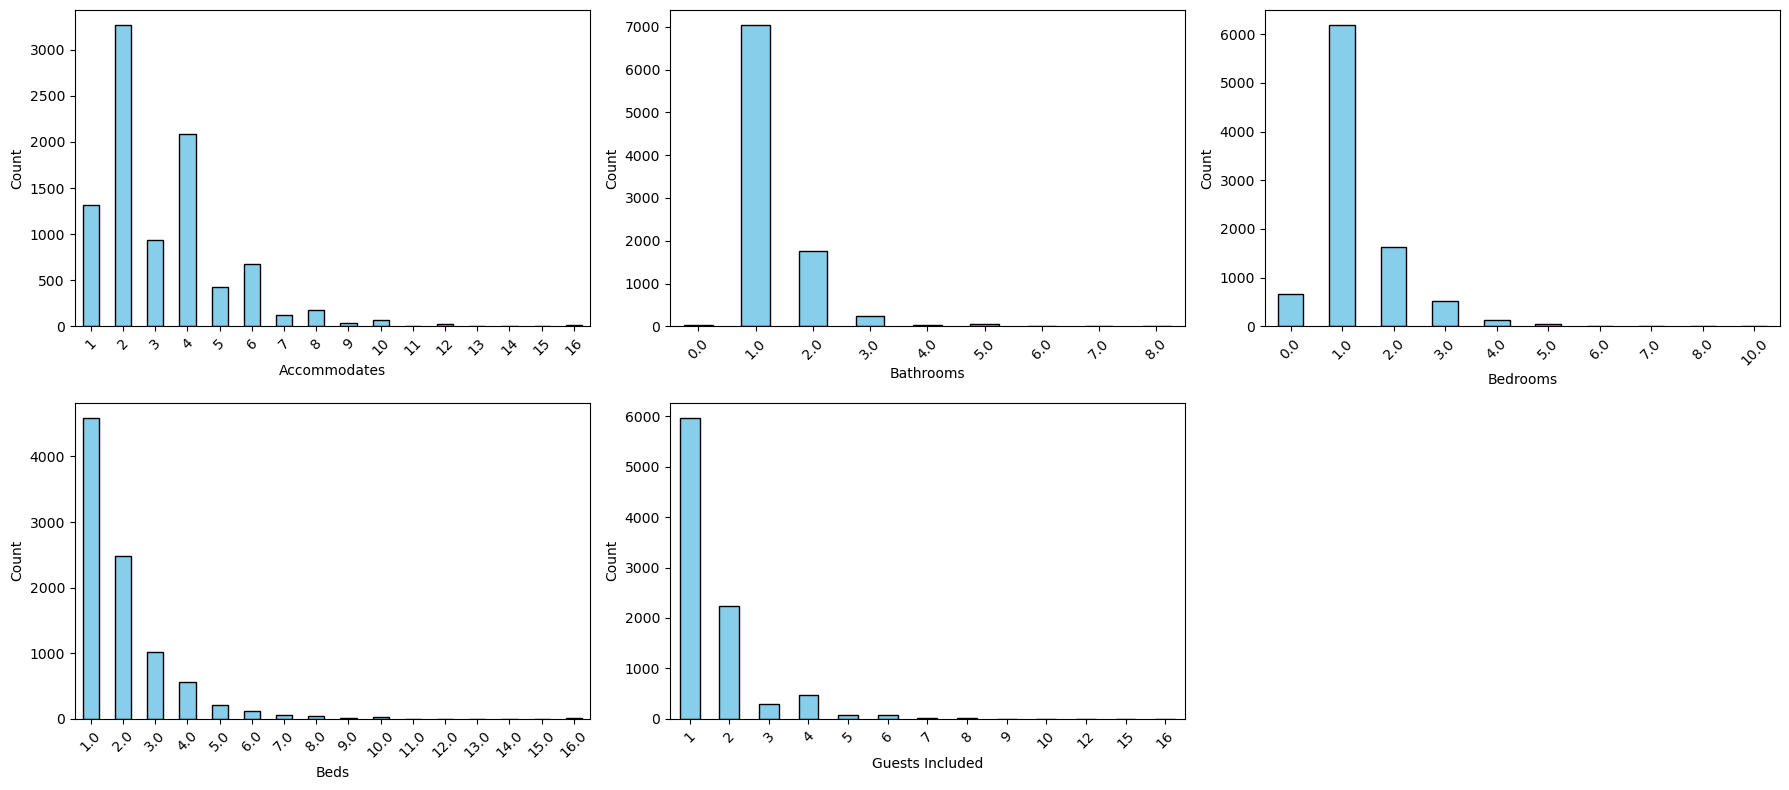

In [19]:
plot_bars(df_train_clean, features['discreteQuantitative'], 2, 3)

Plot qualitative features

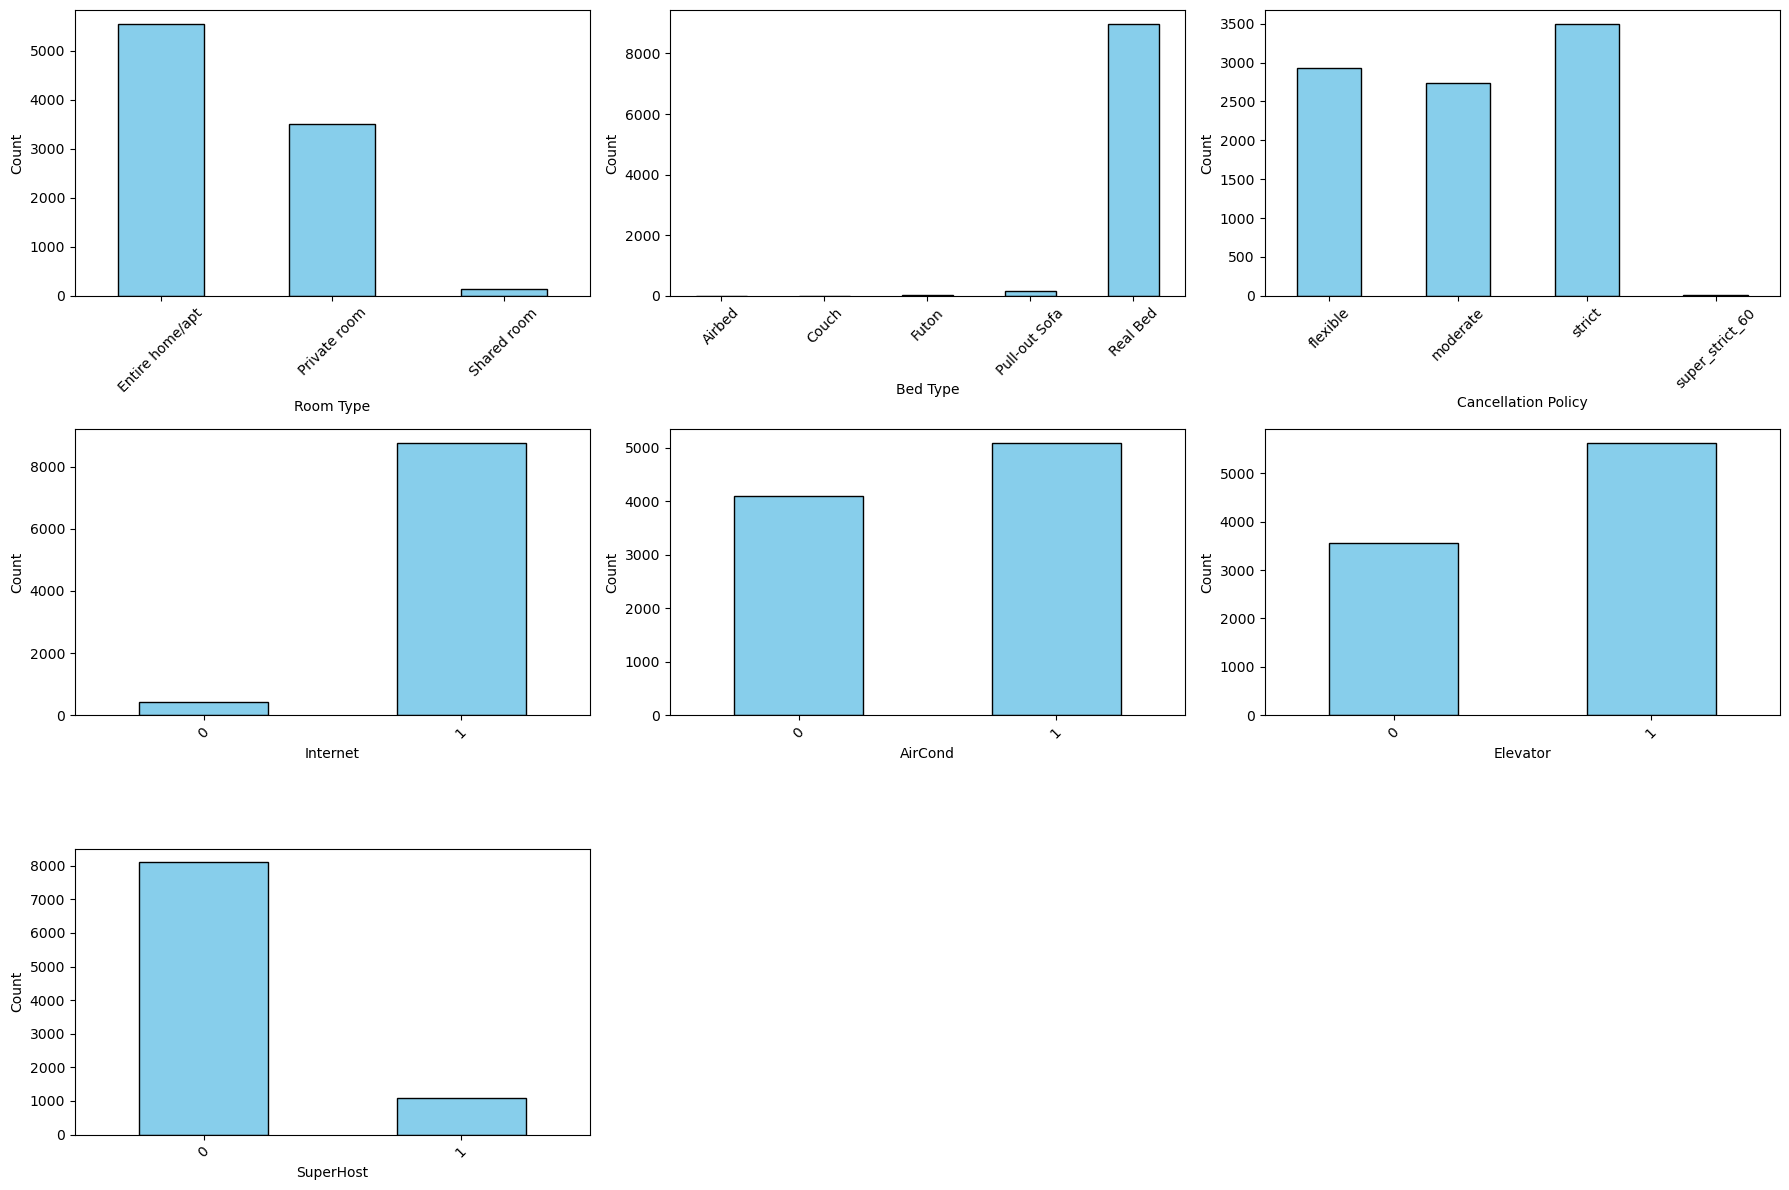

In [20]:
plot_bars(df_train_clean, features['qualitative'], 3, 3)

Plot continuous quantitative features

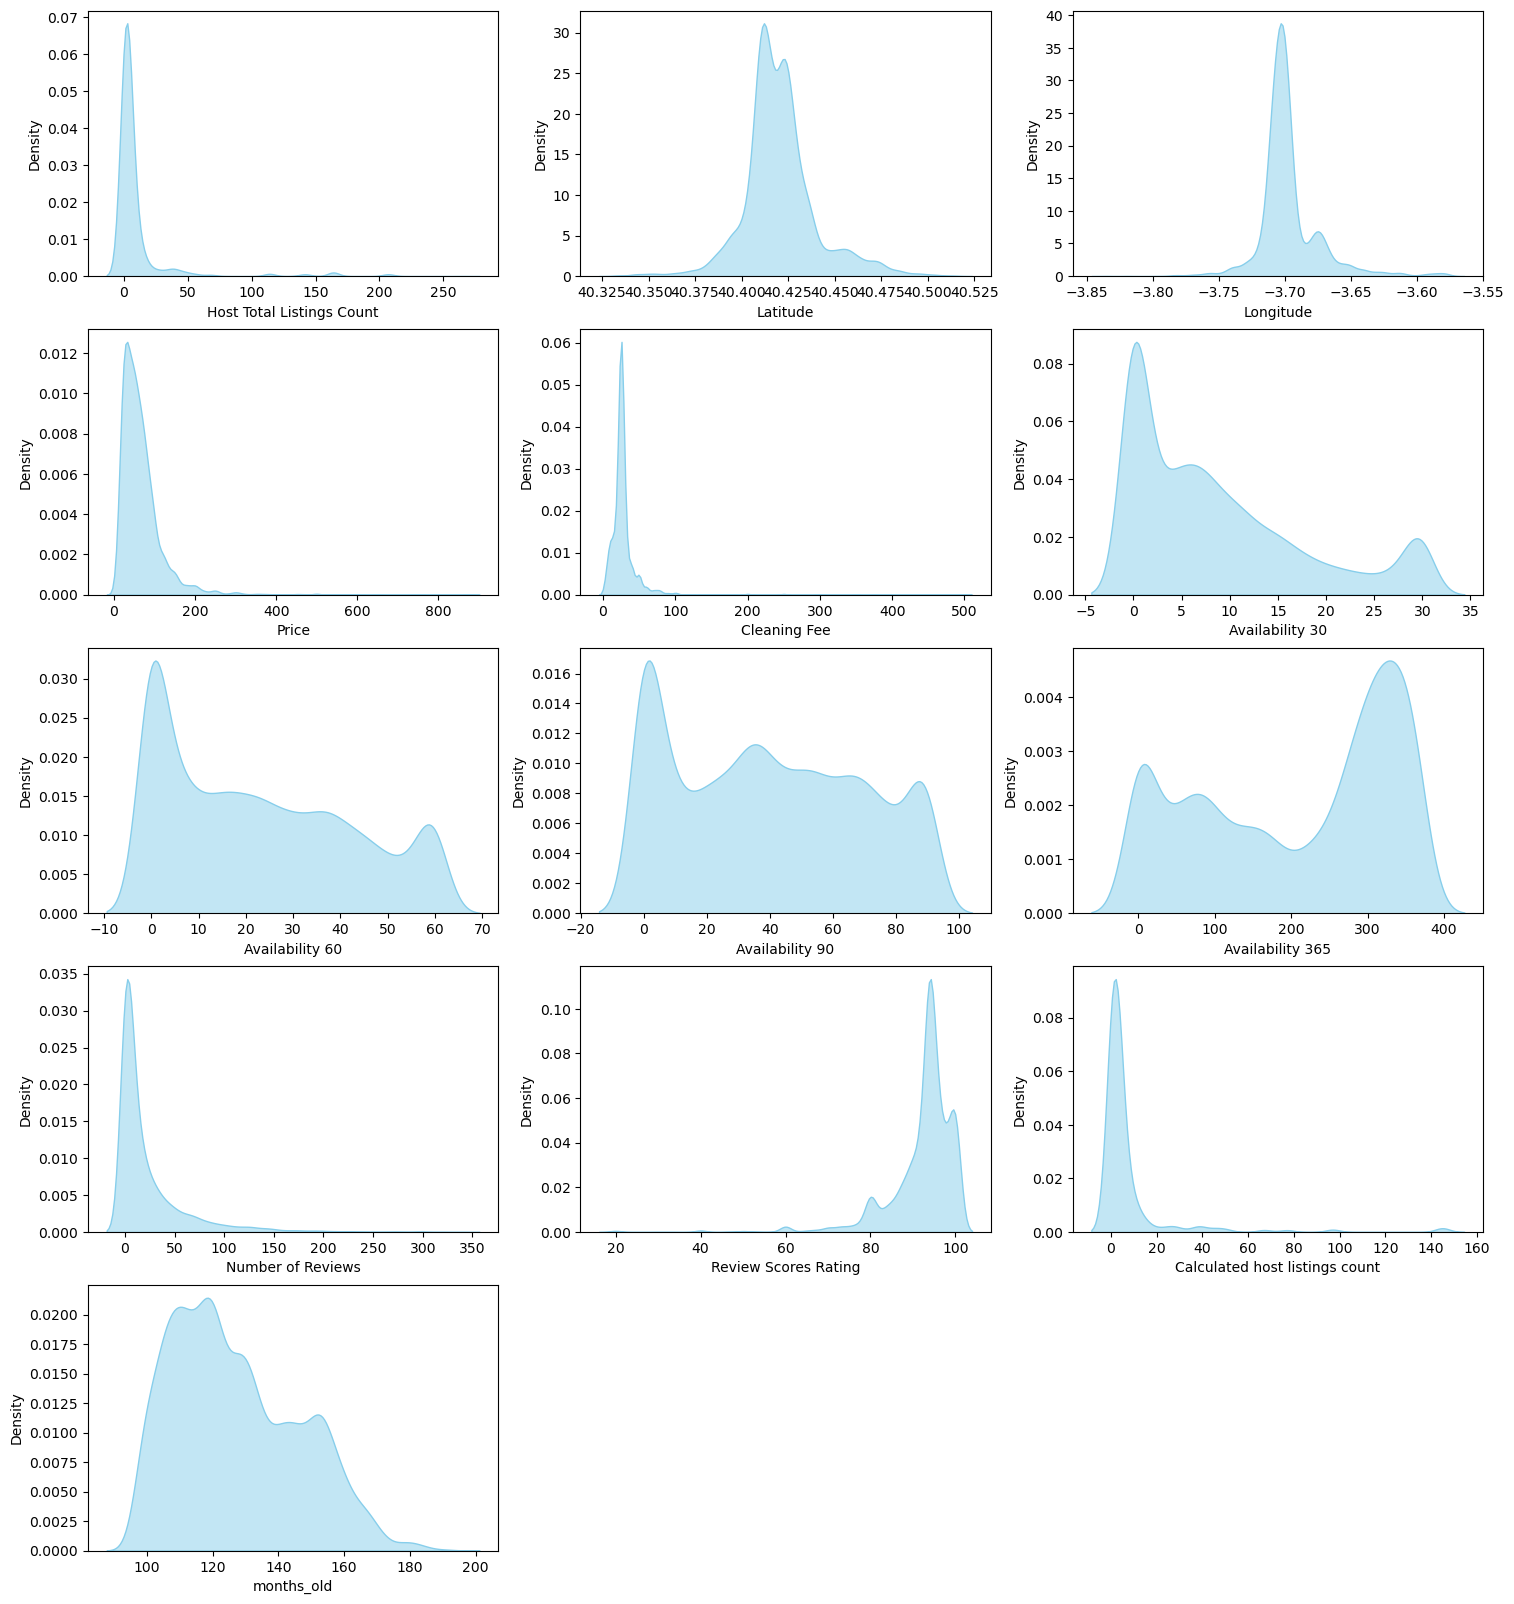

In [21]:
plot_density(df_train_clean, features['contQuantitative'], 5, 3)

#### Correlations between features

Classify estimator and predictors

In [22]:
variables = {'estimator' : 'Price',
            'biQualitative': ['Internet', 'AirCond', 'Elevator', 'SuperHost'],
            'nonbiQualitative': ['Room Type', 'Bed Type', 'Cancellation Policy'],
            'discreteQuantitative': ['Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 
                                     'Guests Included'],
            'contQuantitative': ['Host Total Listings Count', 'Latitude', 'Longitude', 
                                 'Cleaning Fee', 'Availability 30',
                                 'Availability 60', 'Availability 90', 'Availability 365',
                                 'Number of Reviews', 'Review Scores Rating', 
                                 'Calculated host listings count', 'months_old']}

Normalize continuous quantitative variables

In [23]:
from sklearn import preprocessing

# Only standarizate cont quantitative
df_train_clean_to_scale = df_train_clean[variables['contQuantitative']]
df_train_clean_not_to_scale = df_train_clean.drop(variables['contQuantitative'], axis = 1)
scaler = preprocessing.StandardScaler().fit(df_train_clean_to_scale)
train_clean_scaled = scaler.transform(df_train_clean_to_scale)
train_clean_column_names = df_train_clean_to_scale.columns.to_list()

# new dataframe
df_train_scaled = pd.DataFrame(train_clean_scaled, columns = train_clean_column_names)
df_train_scaled = pd.concat([df_train_clean_not_to_scale.reset_index(drop=True), 
                             df_train_scaled.reset_index(drop=True)], axis = 1)

# array discrete and continuous variables
train_scaled = train_clean_scaled,
df_train_clean[variables['discreteQuantitative']].to_numpy()
train_scaled = np.column_stack((train_clean_scaled, 
                                df_train_clean[variables['discreteQuantitative']].to_numpy(),
                                df_train_clean[variables['estimator']].to_numpy()))
column_names = train_clean_column_names + variables['discreteQuantitative'] + [variables['estimator']]
train_scaled.shape

(9181, 18)

Quantitative predictors vs Estimator (PCC and MI)

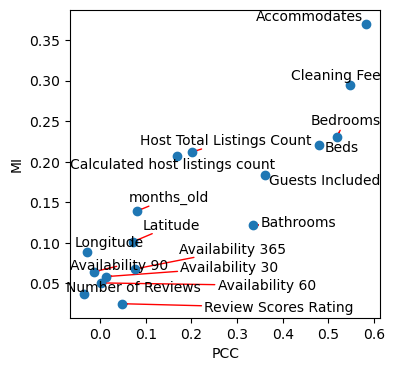

In [24]:
from sklearn.feature_selection import r_regression, mutual_info_regression

features_indexes = get_indexes_from_list(column_names, variables['contQuantitative'] + variables['discreteQuantitative'])
estimator_index = get_indexes_from_list(column_names, variables['estimator'])

r_test = r_regression(
    train_scaled[:,features_indexes], train_scaled[:,estimator_index]).tolist()
mi = mutual_info_regression(
    train_scaled[:,features_indexes], train_scaled[:,estimator_index]).tolist()
features = list(get_elements_from_list(column_names,features_indexes))
feature_stats = {'feature': features, 'pcc': r_test, 'mi': mi}

# Plot scatter plot correlation vs MI
plot_correlation_vs_mi(feature_stats)

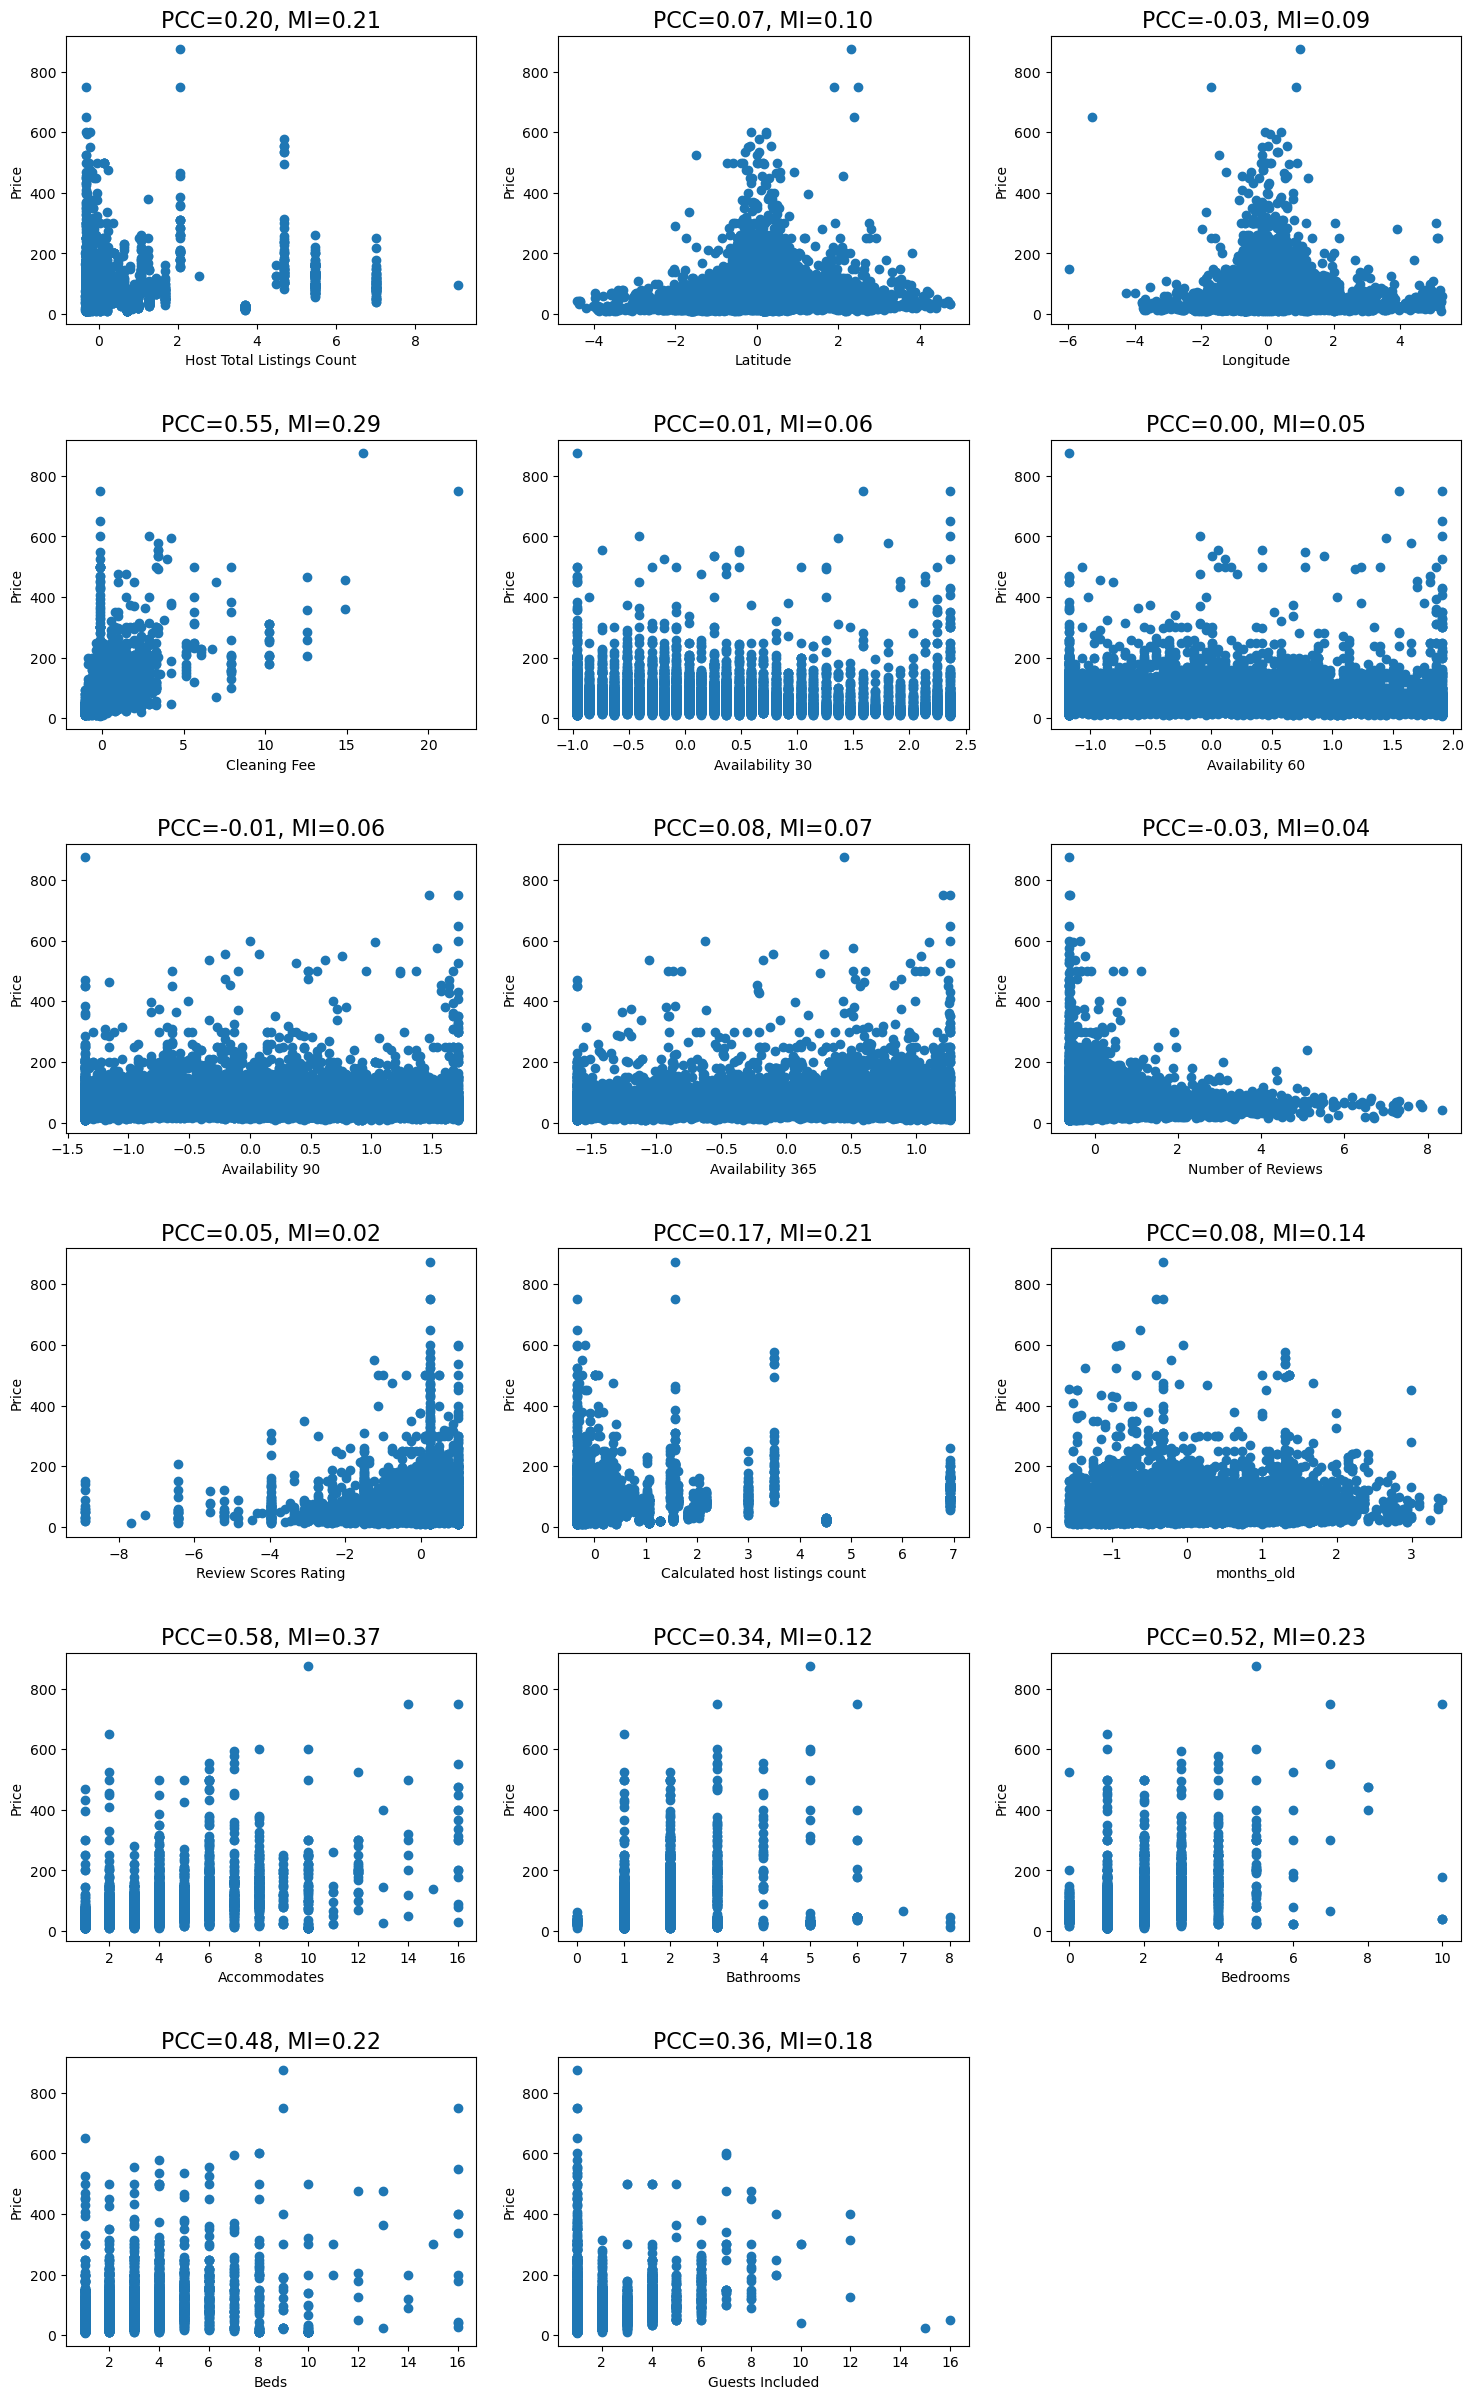

In [25]:
# Scatter plots features/estimator
plot_estimator_feature_contquant(df_train_scaled, variables['estimator'], feature_stats, 6, 3)

Qualitative predictors vs Estimator (t-Test/ANOVA)

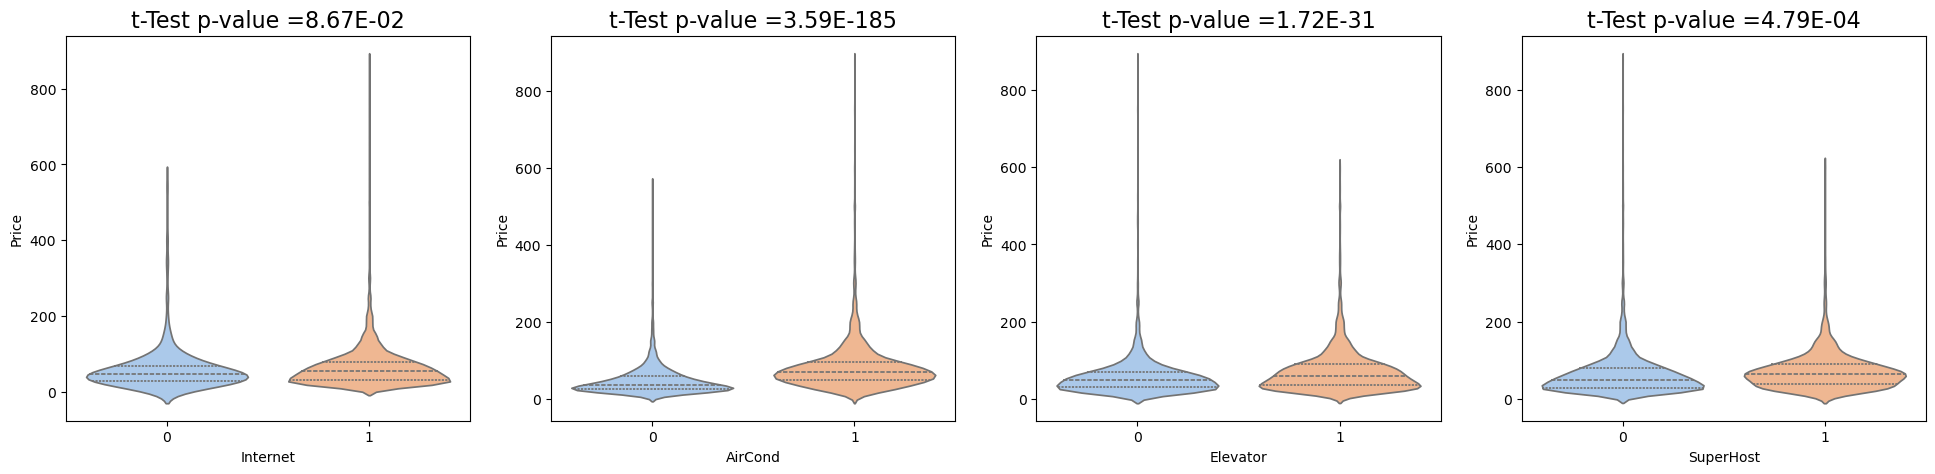

In [26]:
# Qualitative features with two factors:  t-Test
plot_estimator_feature_qualit_bi(df_train_scaled, variables['estimator'], variables['biQualitative'], 1, 4)

PCC between quantitative features (matrix PCC)

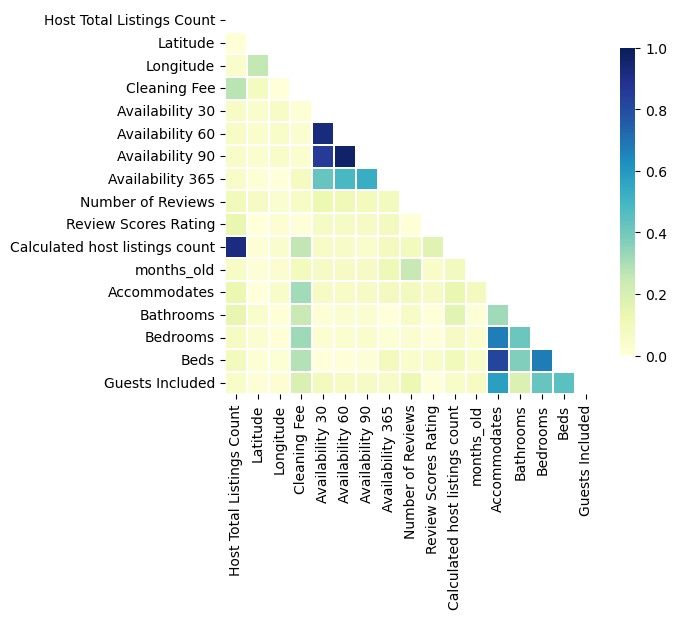

In [27]:
# Compute the correlation matrix
corr = np.abs(df_train_scaled[variables['contQuantitative'] + variables['discreteQuantitative']].corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 5))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

**Calculated host listings count**, **Availability 60**, **Availability 90** and **Beds** are removed from data

In [28]:
df_train_select = df_train_scaled.drop(['Calculated host listings count', 'Availability 60', 'Availability 90', 'Beds'], axis = 1)

#### Train data processing

In [29]:
# select only accomodations in Madrid
df_test_madrid = df_test[df_test['Smart Location'] == 'Madrid, Spain']

# remove unuseful features
df_test_clean = df_test_madrid.drop(features_to_remove, axis=1)

# build features from Amenities
df_test_clean['Internet'] = df_test_clean['Amenities'].str.contains('Internet', na = False).astype(int)
df_test_clean['AirCond'] = df_test_clean['Amenities'].str.contains('Air conditioning', na = False).astype(int)
df_test_clean['Elevator'] = df_test_clean['Amenities'].str.contains('Elevator in building', na = False).astype(int)
df_test_clean = df_test_clean.drop(['Amenities'], axis = 1)

# build feature from Features
df_test_clean['SuperHost'] = df_test_clean['Features'].str.contains('Host Is Superhost', na = False).astype(int)
df_test_clean = df_test_clean.drop(['Features'], axis = 1)

# build feature from Host Since
df_test_clean['Host Since'] = pd.to_datetime(df_test_clean['Host Since'])
today = pd.Timestamp.today()
df_test_clean['months_old'] = (
    (today.year - df_test_clean['Host Since'].dt.year) * 12 + 
    (today.month - df_test_clean['Host Since'].dt.month)
)
df_test_clean = df_test_clean.drop(['Host Since'], axis = 1)

# Manage missing data
# Remove samples without info about Price
df_test_clean = df_test_clean[np.logical_not(df_test_clean['Price'].isna())]
# Remove samples without info about Bathrooms
df_test_clean = df_test_clean[np.logical_not(df_test_clean['Bathrooms'].isna())]
# Remove samples without info about Bedrooms
df_test_clean = df_test_clean[np.logical_not(df_test_clean['Bedrooms'].isna())]
# Remove samples without info about Beds and Bedrooms
df_test_clean = df_test_clean[np.logical_not(df_test_clean['Beds'].isna() & df_test_clean['Bedrooms'].isna())]
# Remove samples without info about months_old
df_test_clean = df_test_clean[np.logical_not(df_test_clean['months_old'].isna())]
# Impute Beds with value from Bedrooms
df_test_clean['Beds'] = df_test_clean['Beds'].fillna(df_test_clean['Bedrooms'])
# Impute sample without info about Cleaning Fee to median
cleaning_fee_median = df_test_clean['Cleaning Fee'].median()
df_test_clean['Cleaning Fee'] = df_test_clean['Cleaning Fee'].fillna(cleaning_fee_median)
# Impute sample without info about Review Scores Rating to median
review_rating_median = df_test_clean['Review Scores Rating'].median()
df_test_clean['Review Scores Rating'] = df_test_clean['Review Scores Rating'].fillna(review_rating_median)
df_test_clean = df_test_clean.drop(['Square Feet', 'Security Deposit'], axis = 1)
na_counts = df_test_clean.isna().sum()
na_counts[na_counts > 0]

Series([], dtype: int64)

In [30]:
# Modify Bathrooms feature
df_test_clean['Bathrooms'] = np.ceil(df_test_clean['Bathrooms'])

In [31]:
# Only standarizate cont quantitative
df_test_clean_to_scale = df_test_clean[variables['contQuantitative']]
df_test_clean_not_to_scale = df_test_clean.drop(variables['contQuantitative'], axis = 1)
scaler = preprocessing.StandardScaler().fit(df_test_clean_to_scale)
test_clean_scaled = scaler.transform(df_test_clean_to_scale)
test_clean_column_names = df_test_clean_to_scale.columns.to_list()

# new dataframe
df_test_scaled = pd.DataFrame(test_clean_scaled, columns = test_clean_column_names)
df_test_scaled = pd.concat([df_test_clean_not_to_scale.reset_index(drop=True), 
                             df_test_scaled.reset_index(drop=True)], axis = 1)

In [32]:
# Remove redundant features
df_test_select = df_test_scaled.drop(['Calculated host listings count', 'Availability 60', 'Availability 90', 'Beds'], axis = 1)

#### Encode categorical variables

Encoding **Room Type**, **Bed Type** and **Cancellation Policy** features

In [33]:
df_train_select['Room Type'].value_counts()

Room Type
Entire home/apt    5552
Private room       3498
Shared room         131
Name: count, dtype: int64

In [34]:
df_train_scaled['Bed Type'].value_counts()

Bed Type
Real Bed         8982
Pull-out Sofa     155
Futon              27
Couch              12
Airbed              5
Name: count, dtype: int64

In [35]:
df_train_scaled['Cancellation Policy'].value_counts()

Cancellation Policy
strict             3501
flexible           2932
moderate           2743
super_strict_60       5
Name: count, dtype: int64

In [36]:
# Combine train and test data temporarily
combined = pd.concat([df_train_select, df_test_select])

# Encode all data at once
combined_encoded = pd.get_dummies(combined, columns=['Room Type', 'Bed Type', 'Cancellation Policy'])

# Split back into train and test
df_train_final = combined_encoded.iloc[:len(df_train_select)]
df_test_final = combined_encoded.iloc[len(df_train_select):]

#### Lasso regression

Parameter optimization (alpha)

best mean cross-validation score: 1360.045
best parameters: {'alpha': np.float64(0.002335721469090121)}


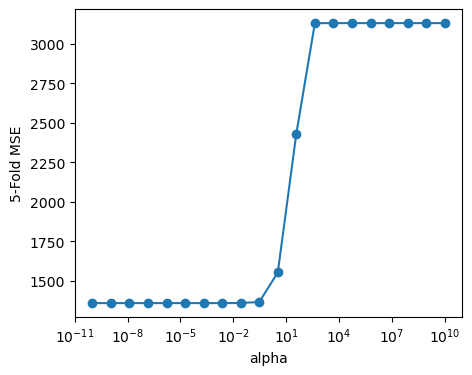

In [37]:
# GridSearch + Lasso
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

alpha_vector = np.logspace(-10,10,20)
predictors = df_train_final.drop([variables['estimator']], axis = 1).columns 
estimator = variables['estimator']
X_train = df_train_final[predictors].to_numpy()
y_train = df_train_final[estimator].to_numpy()

param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(-1*grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

f, ax = plt.subplots(figsize=(5, 4))
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha')
plt.ylabel('5-Fold MSE')
plt.show()

Build lasso regression model

In [38]:
# Lasso regression (best alpha parameter)
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(X_train, y_train)

# Coefficients
w = lasso.coef_
for f,wi in zip(predictors,w.tolist()):
    print(f'{f}: {wi}')

norm_w2 = np.dot(w,w.T)
print(f'\n||w||_2^2 = {norm_w2:.2g}')

# MSE/RMSE train
y_train_predict = lasso.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_predict)
train_rmse = math.sqrt(train_mse)
train_r2 = lasso.score(X_train, y_train)
print(f'\nMSE train: {train_mse}')
print(f'RMSE train: {train_rmse}')
print(f'R2 train: {train_r2}')

# RMSE test
X_test = df_test_final[predictors].to_numpy()
y_test = df_test_final[estimator].to_numpy()
y_test_predict = lasso.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_predict)
test_rmse = math.sqrt(test_mse)
test_r2 = lasso.score(X_test, y_test)
print(f'\nMSE test: {test_mse}')
print(f'RMSE test: {test_rmse}')
print(f'R2 test: {test_r2}')


Accommodates: 5.822096454733204
Bathrooms: 11.008223669492462
Bedrooms: 10.391097192063764
Guests Included: 0.5439461241492701
Internet: -5.449341625759661
AirCond: 7.035107148827237
Elevator: 4.284237289294435
SuperHost: 3.1408203287515395
Host Total Listings Count: 2.2511585989578986
Latitude: 1.3106735557270286
Longitude: -1.4452868245746502
Cleaning Fee: 17.478606923560957
Availability 30: 6.022745960284253
Availability 365: -0.28702324292942205
Number of Reviews: -2.218496128388514
Review Scores Rating: 3.7224381927216506
months_old: 0.7352959334969894
Room Type_Entire home/apt: 27.60542901553857
Room Type_Private room: 0.0
Room Type_Shared room: -13.745558316093357
Bed Type_Airbed: -0.0
Bed Type_Couch: -0.0
Bed Type_Futon: 0.5553187604104004
Bed Type_Pull-out Sofa: -1.5848367837645245
Bed Type_Real Bed: 0.452740239780624
Cancellation Policy_flexible: 4.725783442741925
Cancellation Policy_moderate: -0.0
Cancellation Policy_strict: -0.4689387060847875
Cancellation Policy_super_stri

Predictor importance

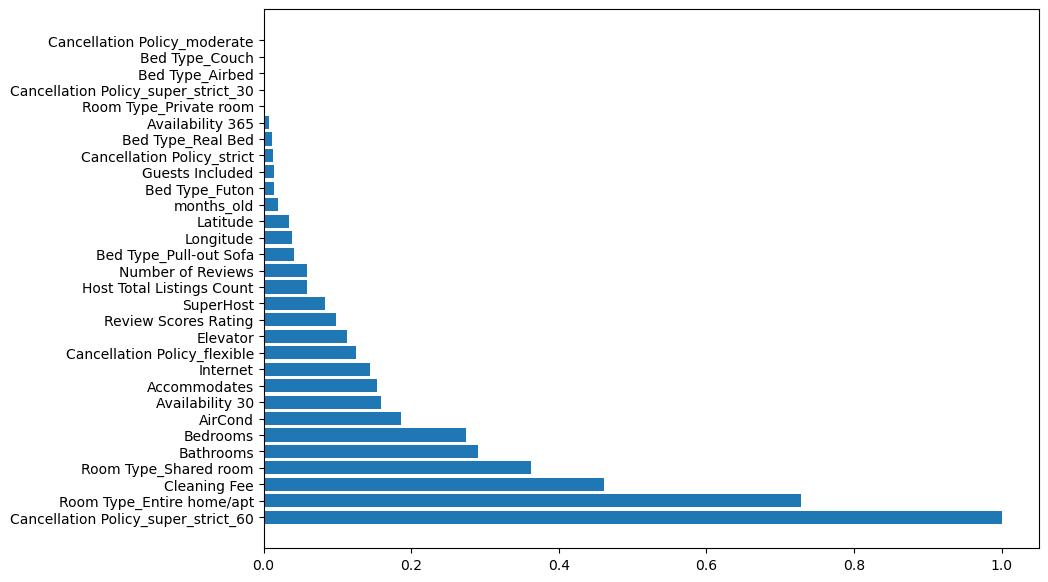

In [39]:
importances = np.abs(lasso.coef_)
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,7))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),predictors[indices])
plt.show()

#### Random Forest

Parameter optimization (max_depth)

In [40]:
# GridSearch + Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

max_depth = range(1,25)
predictors = df_train_final.drop([variables['estimator']], axis = 1).columns 
estimator = variables['estimator']
X_train = df_train_final[predictors].to_numpy()
y_train = df_train_final[estimator].to_numpy()

param_grid = {'max_depth': max_depth }
grid = GridSearchCV(
    RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt', n_jobs=3), 
    scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 5, verbose=1, return_train_score=True)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(-1*grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
best mean cross-validation score: 1031.096
best parameters: {'max_depth': 20}


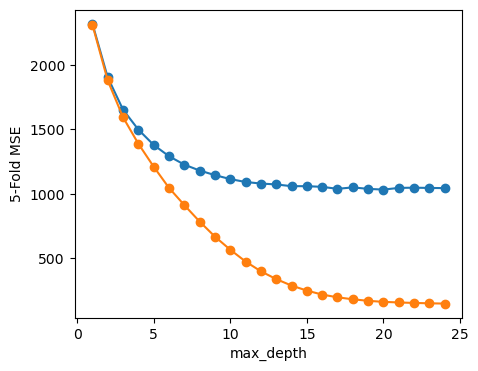

In [41]:
f, ax = plt.subplots(figsize=(5, 4))
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.plot(max_depth,scores,'-o', label="test")
plt.plot(max_depth,np.array(-grid.cv_results_['mean_train_score']),'-o', label="train")
plt.xlabel('max_depth')
plt.ylabel('5-Fold MSE')
plt.show()

Build random forest regressor model

In [42]:
# Random Forest Regressor (best max_depth parameter)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

DepthOptimo = 10
randomForest = RandomForestRegressor(
    max_depth=DepthOptimo, 
    n_estimators=200, 
    max_features='sqrt', 
    random_state = 0).fit(X_train,y_train)

# MSE/RMSE validation
valid_mse = -1*grid.cv_results_['mean_test_score'][11]
valid_rmse = np.sqrt(valid_mse)
print(f'\nMSE valid: {valid_mse}')
print(f'RMSE valid: {valid_rmse}')

# MSE/RMSE train
y_train_predict = randomForest.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_predict)
train_rmse = math.sqrt(train_mse)
train_r2 = randomForest.score(X_train, y_train)
print(f'\nMSE train: {train_mse}')
print(f'RMSE train: {train_rmse}')
print(f'R2 train: {train_r2}')

# RMSE test
X_test = df_test_final[predictors].to_numpy()
y_test = df_test_final[estimator].to_numpy()
y_test_predict = randomForest.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_predict)
test_rmse = math.sqrt(test_mse)
test_r2 = randomForest.score(X_test, y_test)
print(f'\nMSE test: {test_mse}')
print(f'RMSE test: {test_rmse}')
print(f'R2 test: {test_r2}')


MSE valid: 1078.3163050172404
RMSE valid: 32.837726855207876

MSE train: 591.9032130462664
RMSE train: 24.329061080244472
R2 train: 0.8108971564328302

MSE test: 1175.4927042828806
RMSE test: 34.285459079366
R2 test: 0.6139898929969403


Predictor importance

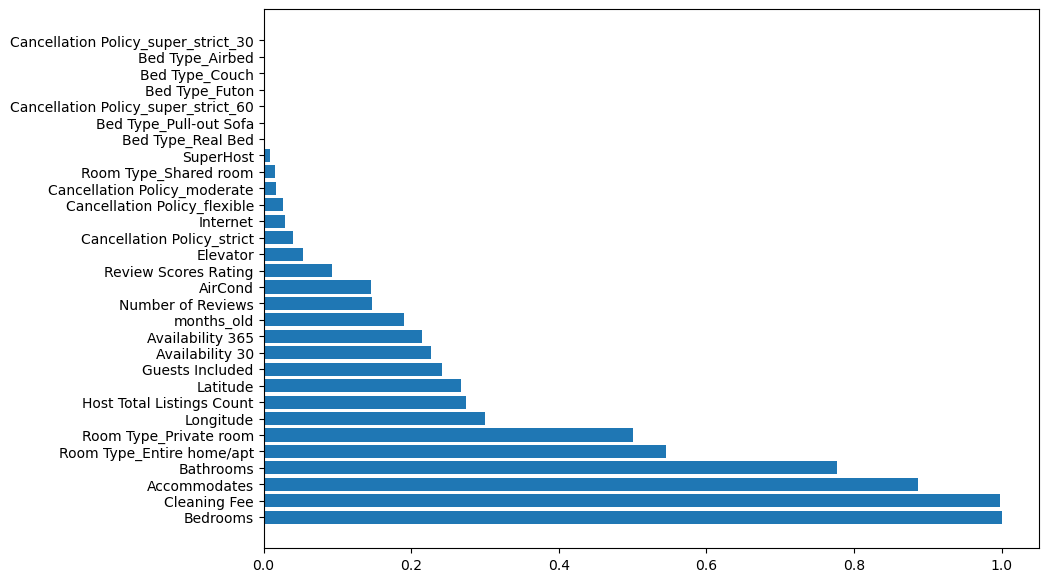

In [43]:
importances = randomForest.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,7))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),predictors[indices])
plt.show()

#### Boosted Trees

Parameter optimization (n_estimators and learning_rate)

In [44]:
# GridSearch + Boosted Trees
from sklearn.ensemble import GradientBoostingRegressor

Niterations = [25,50,100,150,200,300,350,400]
learningRate = [0.5,0.1,0.05,0.01]
# mantenemos max_depth estático: max_depth=2

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(
    GradientBoostingRegressor(random_state=0, max_depth=2), 
    scoring= 'neg_mean_squared_error',
    param_grid=param_grid, cv = 3, 
    verbose=2, n_jobs=3)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(-1*grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

Fitting 3 folds for each of 32 candidates, totalling 96 fits
best mean cross-validation score: 1143.031
best parameters: {'learning_rate': 0.1, 'n_estimators': 400}


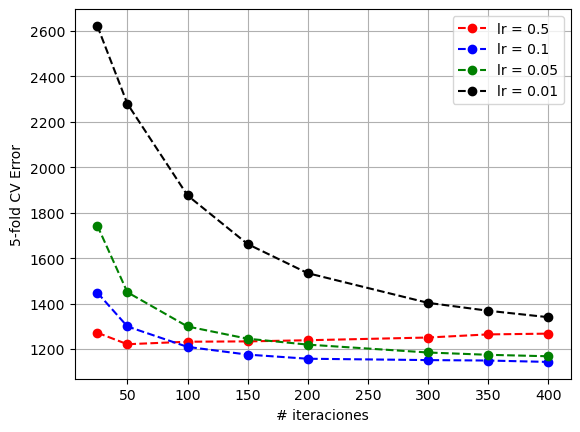

In [45]:
error = -1*grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
#plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()

Build boosted tree model

In [46]:
# Boosted Tree Regressor (best learning rate and n_estimators parameters)
lrOptimo = 0.1
neOptimo = 150
bt = GradientBoostingRegressor(random_state=0, max_depth=2,learning_rate=lrOptimo, n_estimators=neOptimo).fit(X_train,y_train)

# MSE/RMSE validation
valid_mse = -1*grid.cv_results_['mean_test_score'][11]
valid_rmse = np.sqrt(valid_mse)
print(f'\nMSE valid: {valid_mse}')
print(f'RMSE valid: {valid_rmse}')

# MSE/RMSE train
y_train_predict = randomForest.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_predict)
train_rmse = math.sqrt(train_mse)
train_r2 = randomForest.score(X_train, y_train)
print(f'\nMSE train: {train_mse}')
print(f'RMSE train: {train_rmse}')
print(f'R2 train: {train_r2}')

# RMSE test
X_test = df_test_final[predictors].to_numpy()
y_test = df_test_final[estimator].to_numpy()
y_test_predict = randomForest.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_predict)
test_rmse = math.sqrt(test_mse)
test_r2 = randomForest.score(X_test, y_test)
print(f'\nMSE test: {test_mse}')
print(f'RMSE test: {test_rmse}')
print(f'R2 test: {test_r2}')


MSE valid: 1175.2440356245645
RMSE valid: 34.28183244263008

MSE train: 591.9032130462664
RMSE train: 24.329061080244472
R2 train: 0.8108971564328302

MSE test: 1175.4927042828806
RMSE test: 34.285459079366
R2 test: 0.6139898929969403


#### Conclusion

Through data exploration, some predictor variables that could be redundant in the analysis were discarded, for example, **Calculated host listings count**, **Availability 60**, **Availability 90** and **Beds**.
It was also observed that certain qualitative features, such as **Internet** or **SuperHost**, would contribute little information. This observation was later confirmed by the variable relevance analysis performed using a random forest model. Both the variable relevance analysis with L1-regularized linear regression and random forest indicated the low importance of the categorical variable **Bed Type**, which could be removed from the models.

Three regression models were analyzed: L1-regularized linear regression, random forest, and gradient boosted trees. First model yielded the worst results for price prediction. The other two models performed similarly.

In [47]:
# TODO Plot density for qualitative feature vs Price
# TODO Correlations between predictors Quantitative vs Qualitative
# TODO Correlations between predictors Qualitative vs Qualitative
# TODO Correlations between estimator vs predictor ANOVA
# TODO Encode categorical variables with two groups and plot with Yes/No